In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/Shared drives/Dialogue System Final Project')

from huggingface_hub import login

#login(token="")
!huggingface-cli login
!pip install peft


Mounted at /content/drive


# Data Processing

In [3]:
import pandas as pd
file_path = '/content/drive/Shared drives/Dialogue System Final Project/processed_file_with_updated_addressee.csv'
data = pd.read_csv(file_path)
#print(data.head())

data['input'] = data.apply(
    lambda row: f"{row['speaker']}: {row['transcript']} [DA10: {row['dialogue_act_10']}] [DA40: {row['dialogue_act_40']}] [addressee: {row['addressee']}]",
    axis=1
)

input_data = data[data['speaker'] != 'Ross Geller']
ross_responses = data[data['speaker'] == 'Ross Geller']

# combine input and fill na
merged_data = pd.merge(
    input_data,
    ross_responses[['season_id', 'episode_id', 'scene_id', 'transcript']],
    on=['season_id', 'episode_id', 'scene_id'],
    how='left',
    suffixes=('_input', '_ross')
)

merged_data['output'] = merged_data['transcript_ross'].fillna('<token:skip>')

split_point = int(len(merged_data) * 0.01)
merged_data = merged_data.iloc[:split_point]

# train test split
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(merged_data, test_size=0.2)
val_data, test_data = train_test_split(val_data, test_size=0.5)

# ok we really need more memory
#del data, merged_data, input_data, ross_responses

# Model and Training

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, get_scheduler
from peft import LoraConfig, get_peft_model, TaskType
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments
from tqdm import tqdm

lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=32,
    lora_dropout=0.1,
)

model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)#.cuda()
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
model.train()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

def encode_data(data, tokenizer, max_length=128):
    inputs = tokenizer(
        data["input"].tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    outputs = tokenizer(
        data["output"].tolist(),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    inputs["labels"] = outputs["input_ids"]
    return inputs

class DialogueDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

class LazyDialogueDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        inputs = self.tokenizer(
            row["input"],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        outputs = self.tokenizer(
            row["output"],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": outputs["input_ids"].squeeze(0),
        }

# encode data for tokenizer
train_dataset = LazyDialogueDataset(train_data, tokenizer, max_length=128)
val_dataset = LazyDialogueDataset(val_data, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# train
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
num_epochs = 1
num_training_steps = len(train_loader) * num_epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()

    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

model.save_pretrained("/content/drive/Shared drives/Dialogue System Final Project/lora_results")
tokenizer.save_pretrained("/content/drive/Shared drives/Dialogue System Final Project/lora_results")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

trainable params: 425,984 || all params: 1,236,240,384 || trainable%: 0.0345
Epoch 1/1


Epoch 1: 100%|██████████| 912/912 [21:10<00:00,  1.39s/it, loss=0.276]


('/content/drive/Shared drives/Dialogue System Final Project/lora_results/tokenizer_config.json',
 '/content/drive/Shared drives/Dialogue System Final Project/lora_results/special_tokens_map.json',
 '/content/drive/Shared drives/Dialogue System Final Project/lora_results/tokenizer.json')

# Evaluation

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

base_model_name = "meta-llama/Llama-3.2-1B"
base_model = AutoModelForCausalLM.from_pretrained(base_model_name)

tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token
lora_path = "/content/drive/Shared drives/Dialogue System Final Project/lora_results"

model = PeftModel.from_pretrained(base_model, lora_path)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
test_text = "Tell me something about dialogue system. Your response:"
inputs = tokenizer(test_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
inputs = {key: val.to(device) for key, val in inputs.items()}

outputs = base_model.generate(
    inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_length=100,
    num_beams=5,
    temperature=1.0,
    top_k=50,
    top_p=0.9,
    repetition_penalty=1.2,
    pad_token_id=tokenizer.pad_token_id
)

base_generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Base Model Generated Text: {base_generated_text}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

#print(f"len {len(test_data)}")
def find_common_words(str1, str2):
    words1 = set(str1.lower().split())
    words2 = set(str2.lower().split())

    common_words = words1.intersection(words2)
    if common_words:
      return True

def get_response(content):
  inputs = tokenizer(test_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
  inputs = {key: val.to(device) for key, val in inputs.items()}

  outputs = model.generate(
      inputs["input_ids"],
      attention_mask=inputs["attention_mask"],
      max_length=100,
      num_beams=5,
      temperature=1.0,
      top_k=50,
      top_p=0.9,
      repetition_penalty=1.2,
      pad_token_id=tokenizer.pad_token_id
  )

  response = tokenizer.decode(outputs[0], skip_special_tokens=True)
  return response

def prompt_addr(context, row):
  request_content = (
            f"Given the following dialogue context, predict the addressee of the current dialogue. "
            f"Output only the name.\n"
            f"Context:\n{context}\n"
            f"Current Dialogue: {row['speaker']}: {row['transcript']}\nAddressee: "
        )
  return request_content

def prompt_act(context, row):
  request_content = (
            f"Given the following dialogue context, predict the speech act of the current dialogue. "
            f"Your answer should be 1 of the 10 possible acts: Statement, Question, Acknowledgment, Agreement, Disagreement, Request, Apology, Greeting, Offer, Clarification. \n"
            f"Output only the answer.\n"
            f"Context:\n{context}\n"
            f"Current Dialogue: {row['speaker']}: {row['transcript']}\nAddressee: "
        )
  return request_content




def evaluate_addr(inputs):
  total = 0
  correct = 0
  last_5 = []
  for _, row in test_data.iterrows():
    if 'token:skip' in row['transcript'] or pd.isna(row['dialogue_act_10']):
      continue

    context = "\n".join([f"{elem['speaker']}: {elem['transcript']} [Addressee: {elem['addressee']}]" for elem in last_5])
    request_content = prompt_act(context, row)
    response = get_response(request_content)
    #print(f"gold: {row['addressee']}, pred: {response['content']}, request: {request_content}, resp: {response}")
    if find_common_words(row['addressee'], response['content']):
      correct += 1
    total += 1

    last_5.append({
            "transcript": row['transcript'],
            "speaker": row['speaker'],
            "addressee": row['addressee'],
            "dialogue_act_10": row['dialogue_act_10']
        })
    if len(last_5) > 5:
      last_5.pop(0)

    gold = row['dialogue_act_10']
    pred = response['content']
    print(f"gold: {gold}, pred: {pred}")
    if find_common_words(gold, pred):
      correct += 1
    total += 1
  accuracy = correct / total
  return accuracy

#acc = evaluate_addr(test_data)
#print(f"acc: {acc:.2%}")

def prompt_skip(row):
  request_content = (
            f"Given the following Friends dialogue context, predict if Ross Geller will respond to the dialogue."
            f"Your answer should be TRUE if you believe if Ross Geller will respond, or FALSE if you believe Ross Geller will skip this turn.\n"
            f"Output only the TRUE or FALSE.\n"
            #f"Context:\n{context}\n"
            f"Current Dialogue: {row.speaker}: {row.transcript}\n Answer: "
        )
  return request_content

def evaluate_skip(inputs):
  total = 0
  correct = 0
  for current_row, next_row in zip(test_data.itertuples(), test_data.iloc[1:].itertuples()):
    if 'token:skip' in current_row.transcript:
      continue
    request_content = prompt_skip(current_row)
    response = get_response(request_content)
    if "true" in response['content'].lower() and 'token:skip' not in next_row.transcript:
      correct += 1
    elif "false" in response['content'].lower() and 'token:skip' in next_row.transcript:
      correct += 1
    total += 1
  accuracy = correct / total
  return accuracy

acc = evaluate_skip(test_data)
print(f"acc: {acc:.2%}")





acc: 60.00%


In [ ]:
print(f"acc: {acc:.2%}")

acc: 42.86%


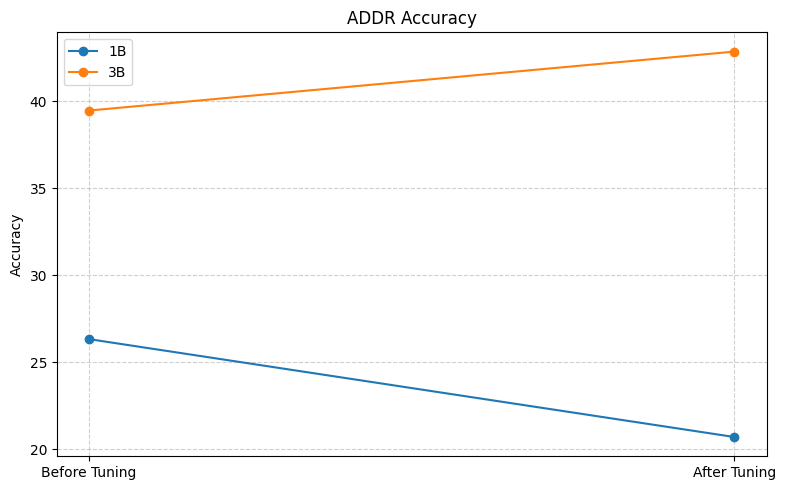

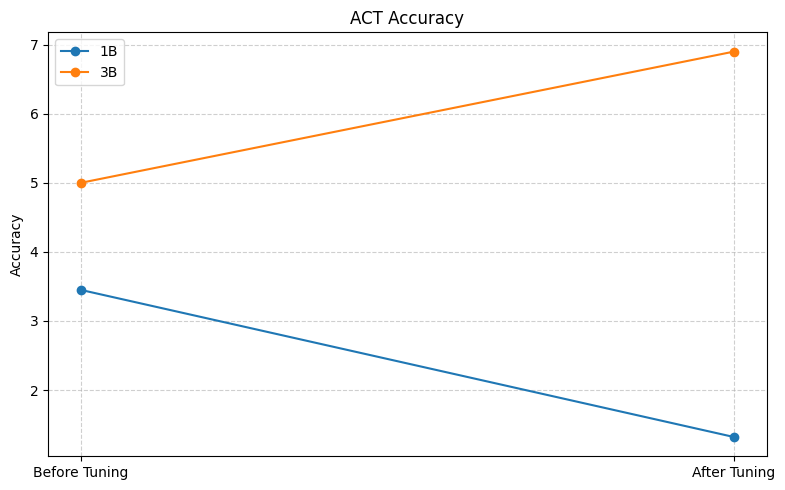

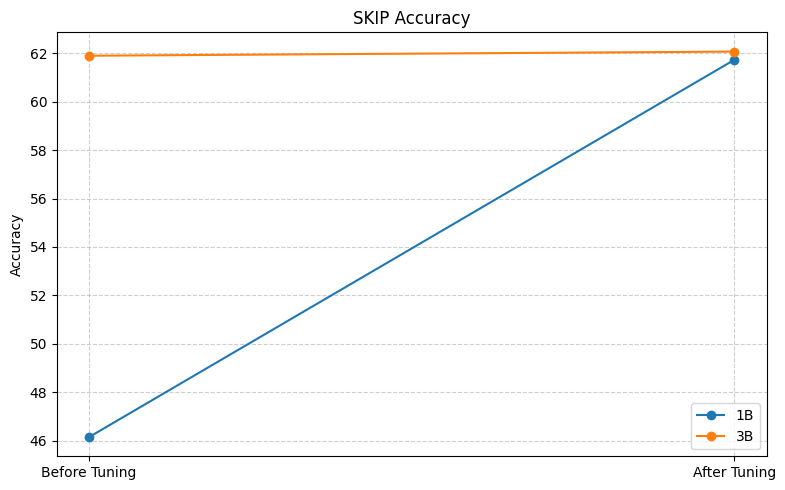

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

tuning = ["Before Tuning", "After Tuning"]
data = {
    "ADDR": {
        "1B": [26.32, 20.69],
        "3B": [39.47, 42.86],
    },
    "ACT": {
        "1B": [3.45, 1.32],
        "3B": [5.00, 6.90],
    },
    "SKIP": {
        "1B": [46.15, 61.73],
        "3B": [61.90, 62.07],
    }
}
for metric, values in data.items():
    fig, ax = plt.subplots(figsize=(8, 5))
    for model, acc in values.items():
        ax.plot(tuning, acc, marker='o', label=f'{model}')

    ax.set_title(f'{metric} Accuracy')
    ax.set_xticks(np.arange(len(tuning)))
    ax.set_xticklabels(tuning)
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_perplexity(model, tokenizer, sentences):
  total_loss = 0.0
  total_tokens = 0
  model.eval()
  ppl_list = []
  for idx, sentence in enumerate(sentences):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, return_attention_mask=True).to("cuda")
    if tokenizer.pad_token is None:
      tokenizer.pad_token = tokenizer.eos_token
    with torch.no_grad():
      outputs = model(**inputs, labels=inputs["input_ids"])
      loss = outputs.loss
    total_loss += loss.item() * inputs["input_ids"].size(1)
    total_tokens += inputs["input_ids"].size(1)

    generated_ids = model.generate(inputs["input_ids"],max_length=inputs["input_ids"].size(1) +128,pad_token_id=tokenizer.pad_token_id,num_beams=5,no_repeat_ngram_size=2,early_stopping=True,)
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    #generated_new_text = generated_text[len(sentence):].strip()
    generated_new_text = generated_text

    if generated_new_text:
      gen_inputs = tokenizer(generated_new_text, return_tensors="pt", truncation=True, padding=True, return_attention_mask=True).to("cuda")
      with torch.no_grad():
        gen_outputs = model(input_ids=gen_inputs["input_ids"],attention_mask=gen_inputs["attention_mask"], labels=gen_inputs["input_ids"])
        gen_loss = gen_outputs.loss
      gen_ppl = torch.exp(gen_loss).item()
      sentence_ppl = torch.exp(loss).item()
      ppl_list.append((gen_ppl + sentence_ppl) /2)
      if sentence_ppl > 5000 or sentence_ppl < 30:
        print(f"Perplexity for Sentence {idx + 1}: {sentence_ppl:.4f}, sentence: {sentence}")

  perplexity = torch.exp(torch.tensor(total_loss / total_tokens)).item()
  print(f"Total Perplexity: {perplexity}")
  return perplexity, ppl_list

test_data = data[48000:49000]
sentences = []
for _, row in test_data.iterrows():
  sentences.append(f"{row['transcript']}")

ppl, ppl_list = evaluate_perplexity(model, tokenizer, sentences)
#evaluate_perplexity(base_model, tokenizer, sentences)

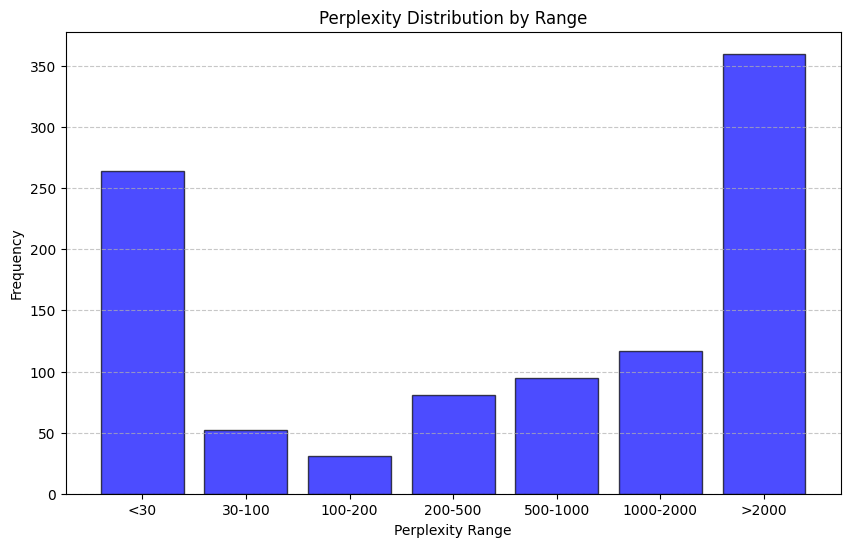

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
bins = ["<30", "30-100", "100-200", "200-500", "500-1000", "1000-2000", ">2000"]
categories = [0, 30, 100, 200, 500, 1000, 2000, float('inf')]
binned_counts = [0] * len(bins)

# Count PPL occurrences in each bin
for ppl in ppl_list:
    for i in range(len(categories) - 1):
        if categories[i] <= ppl < categories[i + 1]:
            binned_counts[i] += 1
            break

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(bins, binned_counts, color="blue", alpha=0.7, edgecolor="black")
plt.title("Perplexity Distribution by Range")
plt.xlabel("Perplexity Range")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Unused**

In [ ]:
!pip install torch transformers evaluate nltk scipy
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from evaluate import load
from nltk.translate.meteor_score import meteor_score
from scipy.spatial.distance import cosine
import numpy as np

test_inputs = test_data['input'].tolist()
test_outputs = test_data['output'].tolist()

model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_meteor(predictions, references):
    scores = [meteor_score([ref], pred) for pred, ref in zip(predictions, references)]
    return np.mean(scores)

def evaluate_bert_similarity(predictions, references):
    similarity_scores = []
    for pred, ref in zip(predictions, references):
        pred_embedding = model(**tokenizer(pred, return_tensors="pt", truncation=True, padding=True).to("cuda")).last_hidden_state.mean(dim=1)
        ref_embedding = model(**tokenizer(ref, return_tensors="pt", truncation=True, padding=True).to("cuda")).last_hidden_state.mean(dim=1)
        similarity = 1 - cosine(pred_embedding.detach().cpu().numpy(), ref_embedding.detach().cpu().numpy())
        similarity_scores.append(similarity)
    return np.mean(similarity_scores)

def evaluate_perplexity(model, tokenizer, sentences):
    total_loss = 0.0
    total_tokens = 0
    model.eval()
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True).to("cuda")
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
        total_loss += loss.item() * inputs["input_ids"].size(1)  # 乘以 token 数
        total_tokens += inputs["input_ids"].size(1)
    perplexity = torch.exp(torch.tensor(total_loss / total_tokens))
    return perplexity.item()

def generate_predictions(inputs):
    predictions = []
    for inp in inputs:
        inputs_encoded = tokenizer(inp, return_tensors="pt", truncation=True, padding=True).to("cuda")
        output_ids = model.generate(inputs_encoded["input_ids"], max_length=50, num_return_sequences=1)
        predictions.append(tokenizer.decode(output_ids[0], skip_special_tokens=True))
    return predictions


print("Generating predictions...")
predictions = generate_predictions(test_inputs)

print("Evaluating METEOR...")
meteor = evaluate_meteor(predictions, test_outputs)

print("Evaluating BERT Similarity...")
bert_similarity = evaluate_bert_similarity(predictions, test_outputs)

print("Evaluating Perplexity...")
perplexity = evaluate_perplexity(model, tokenizer, test_inputs)

print(f"METEOR Score: {meteor:.4f}")
print(f"BERT Similarity: {bert_similarity:.4f}")
print(f"Perplexity: {perplexity:.4f}")
